## Race Predictions ##
### An exploration of data forcasting techniques so I don't forgot how data works in python ###

In [195]:
import requests
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, date
import numpy as np

#### Load Data ####

For the data, I will be using the  'jolpi.ca F1 API' which can be found [here](https://api.jolpi.ca/ergast/).

At first I played around with the idea of loading and structuing all the data myself, although this was far less performant and would require the split into testing and training data manually,
So instead I will be using Pandas.

For now, I have each race in a seperate DF but later I will combine them into a single dataframe with a race ID column for actual modelling. But this looks nicer for data visualisation for now

----
##### New parameters #####
Since we will also be implementing hyoerparameter tuning, for now I will just add as many parameters from the API as I can for each specific race. This will included as much data as available from qualifying, practices and sprints where applicable. In the future I would also love to get additional information from other sources like which teams/cars have had upgrades made since this can impact the weekend performance, but this is likely to be far in the future as it will take a great deal more work. I expect this will only be possible using something like headline scanning on new sources or another API I haven't found / don't have access too. Alteratively I can just add these manually if I am just working on a single season and built it up incrementally, but this is a lot of manual interaction and has lots of potential for me to miss data ... not that using a news headline parser would be any more accurate ;)

Additionally, since there is only so much information we can gather about the driver performance, it is also important to consider external factors of the races and how these could impact performance in the model. For example, we can look at environmental conditions of secific races and how they can impact specific driver or constructor peformance, or how the time between races correlates to the amount of changes and preperation that can be made by teams and drivers. Envirnonmental impacts themselves is an interesting addition, because to use this in the prediction of the future race data, we will be relying on forecasted data that could turn out to be incorrect, which is important to consider.

Finally, I think it is worth considering experience over multiple seasons, as this has impact on driver performance. While I expect this to hugely increase the training time, its important to consider how more experienced drivers may have previous experience winning races at some circuits and such information can potentionally impact the model accuracy. When this is added, its important to at this stage include information on the recency of the race and which season and constructor each driver was with at this stage, so it looks like all information we are currently gathering can impact this.

In [196]:
# Output data in pandas dataframe
years = [2022, 2023, 2024]
current_year = 2024#int(date.today().strftime("%Y"))
race_dataframes = {}
raceID = [0]
last_race = ["none"]

def lap_time_to_ms(lap_time):
    if not lap_time:
        return 0
    minutes, seconds = lap_time.split(":")
    total_ms = int(minutes) * 60 * 1000 + int(float(seconds) * 1000)
    return total_ms

def getWholeSeasonData(year):
    base_url = f"http://api.jolpi.ca/ergast/f1/{year}/results"
    qualifying_url = f"https://api.jolpi.ca/ergast/f1/{year}/qualifying"
    limit = 100
    offset = 0

    response = requests.get(f"{base_url}?limit={1}&offset={offset}").json()
    total_results = int(response["MRData"]["total"])

    ### Get grid positions
    while offset < total_results:
        response = requests.get(f"{base_url}?limit={limit}&offset={offset}").json()
        results = response["MRData"]["RaceTable"]["Races"]

        for race in results:
            race_name = race["raceName"]
            if (last_race[0] != race_name):
                raceID[0] += 1
                last_race[0] = race_name
            if race_name not in race_dataframes:
                race_dataframes[race_name] = []
            race_circuit = race["Circuit"]["circuitName"]
            date = race["date"]
            days_since = (datetime.now() - datetime.strptime(date, "%Y-%m-%d")).days
            ### Here we have access to the location of the circuit. use this to get weather information from the certain date
            ### Or get our prediction for the weather

            for res in race["Results"]:
                race_dataframes[race_name].append({
                    "Circuit": race_circuit,
                    "DaySinceRaceWeight": 1 / (days_since + 1),
                    "RaceYear": year-current_year,
                    "DriverCode": res["Driver"]["code"],
                    "ConstructorId": res["Constructor"]["constructorId"],
                    "StartingPosition": int(res["grid"]) -1,
                    "RaceResult": int(res["position"]) - 1,
                    "PositionsGained": int(res["grid"]) - int(res["position"]),
                    "RaceId": int(raceID[0])
                })
        offset += limit

    offset = 0
    response = requests.get(f"{qualifying_url}?limit={1}&offset={offset}").json()
    total_results = int(response["MRData"]["total"])

    ### Get qualifying times
    while offset < total_results:
        response = requests.get(f"{qualifying_url}?limit={limit}&offset={offset}").json()
        results = response["MRData"]["RaceTable"]["Races"]

        for race in results:
            race_name = race["raceName"]
            for entry in race_dataframes[race_name]:
                driver = entry["DriverCode"]

                match = next( (result for result in race["QualifyingResults"] if result["Driver"]["code"] == driver), None )
                if match:
                    entry["Q1TimeMS"] = lap_time_to_ms(match.get("Q1"))
                    q2_time = lap_time_to_ms(match.get("Q2"))
                    entry["Q2TimeMs"] = q2_time
                    entry["Q2Progress"] = 1 if q2_time else 0
                    q3_time = lap_time_to_ms(match.get("Q3"))
                    entry["Q3TimeMs"] = q3_time
                    entry["Q3Progress"] = 1 if q3_time else 0
        offset += limit

### Get previous season results
### Basically we want everything the same as above but repeated in pervious seasons
### It is worth considering how much time we should go back, do we do it until the oldest driver's first season? 
### or do we go for each constructor? Well this is getting silly now so lets just start with a couple previous seasons as the further 
### back we go the less important it will become
for year in years:
    getWholeSeasonData(year)


In [197]:
for race_name in race_dataframes:
    race_dataframes[race_name] = pd.DataFrame(race_dataframes[race_name])

bahrain_data = race_dataframes["Azerbaijan Grand Prix"]
print("Results for Azerbaijan:")
print(bahrain_data[bahrain_data['RaceYear'] == 0])

Results for Azerbaijan:
              Circuit  DaySinceRaceWeight  RaceYear DriverCode ConstructorId  \
40  Baku City Circuit            0.005882         0        PIA       mclaren   
41  Baku City Circuit            0.005882         0        LEC       ferrari   
42  Baku City Circuit            0.005882         0        RUS      mercedes   
43  Baku City Circuit            0.005882         0        NOR       mclaren   
44  Baku City Circuit            0.005882         0        VER      red_bull   
45  Baku City Circuit            0.005882         0        ALO  aston_martin   
46  Baku City Circuit            0.005882         0        ALB      williams   
47  Baku City Circuit            0.005882         0        COL      williams   
48  Baku City Circuit            0.005882         0        HAM      mercedes   
49  Baku City Circuit            0.005882         0        BEA          haas   
50  Baku City Circuit            0.005882         0        HUL          haas   
51  Baku City Ci

#### Basic Data Visualisation ####

Just to get a bit of a look at the data before we try some forcasting

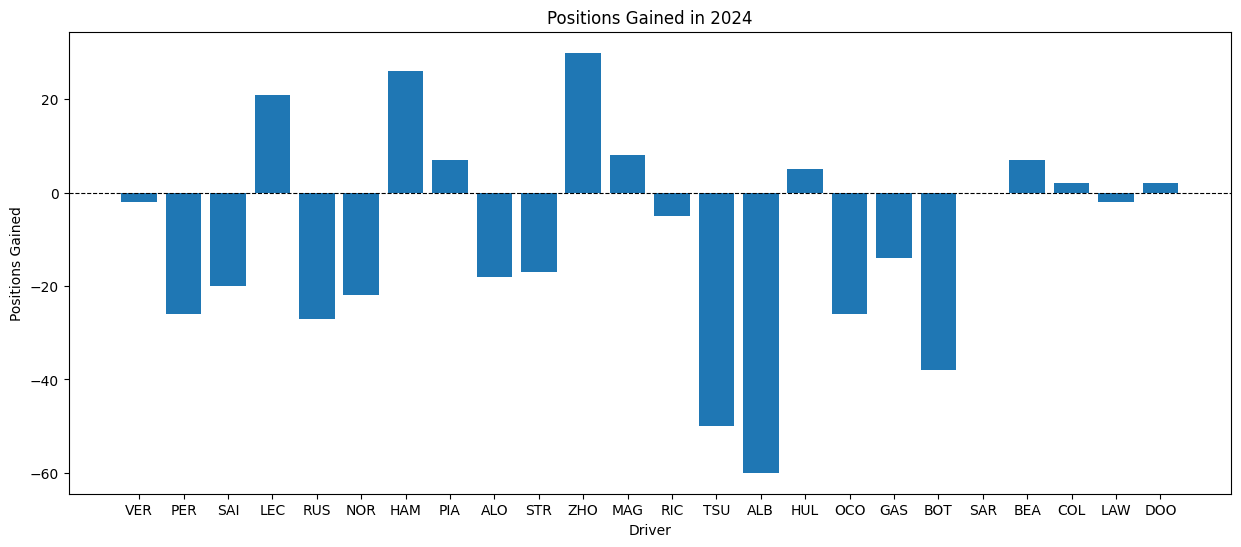

In [198]:
import matplotlib.pyplot as plt

filtered_race_dataframes = {
    race_name: df[df['RaceYear'] == 0] for race_name, df in race_dataframes.items()
}

# Total positions gained over the season
# Obviously insanely flawed because it doesn't take into account starting positions and includes anomaly like DNF
position_gained = {}

for race_name, df in filtered_race_dataframes.items():
    for _, row in df.iterrows(): 
        driver_code = row["DriverCode"]
        positions_gained = row["PositionsGained"]
        
        if driver_code not in position_gained:
            position_gained[driver_code] = 0
        position_gained[driver_code] += positions_gained

positions_gained_df = pd.DataFrame(list(position_gained.items()), columns=["DriverCode", "PositionsGained"])

plt.figure(figsize=(15, 6))
plt.bar(positions_gained_df['DriverCode'], positions_gained_df['PositionsGained'])
plt.title(f'Positions Gained in 2024')
plt.xlabel('Driver')
plt.ylabel('Positions Gained')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

**Why does this look so negative?**

In terms of starting positions, there is not a number grid position for drivers who start in the pits, and the API returns it as 0. If the driver starts in position 0 then any result, even a 1st place, will be considered a negative result which hugely scew the results.

In order to fix this, we can just manually replace all these 0 values in the starting position with a heuristic calculated starting position. But what if there are multiple starting in the pits? Well there isn't really a way to know, so for now we will just assign this at random.

In [199]:
for race_name, df in filtered_race_dataframes.items():
    copy_df = df.copy() 
    max_position = copy_df["StartingPosition"].max()
    
    zero_indices = copy_df.index[copy_df["StartingPosition"] == -1]
    for i, idx in enumerate(zero_indices, start=1):
        copy_df.loc[idx, "StartingPosition"] = max_position + i
    copy_df.loc[:, "PositionsGained"] = copy_df["StartingPosition"] - copy_df["RaceResult"]
    filtered_race_dataframes[race_name] = copy_df




print("Results for Azerbaijan:")
print(filtered_race_dataframes["Azerbaijan Grand Prix"])

Results for Azerbaijan:
              Circuit  DaySinceRaceWeight  RaceYear DriverCode ConstructorId  \
40  Baku City Circuit            0.005882         0        PIA       mclaren   
41  Baku City Circuit            0.005882         0        LEC       ferrari   
42  Baku City Circuit            0.005882         0        RUS      mercedes   
43  Baku City Circuit            0.005882         0        NOR       mclaren   
44  Baku City Circuit            0.005882         0        VER      red_bull   
45  Baku City Circuit            0.005882         0        ALO  aston_martin   
46  Baku City Circuit            0.005882         0        ALB      williams   
47  Baku City Circuit            0.005882         0        COL      williams   
48  Baku City Circuit            0.005882         0        HAM      mercedes   
49  Baku City Circuit            0.005882         0        BEA          haas   
50  Baku City Circuit            0.005882         0        HUL          haas   
51  Baku City Ci

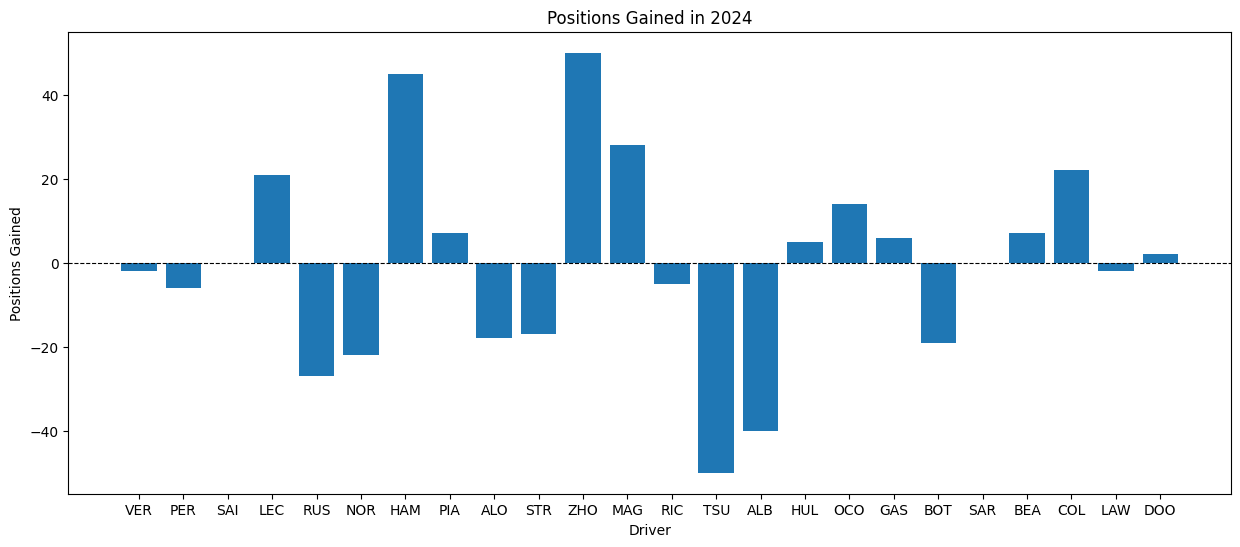

In [200]:
total_positions_gained = {}

for race_name, df in filtered_race_dataframes.items():
    for _, row in df.iterrows(): 
        driver_code = row["DriverCode"]
        positions_gained = row["PositionsGained"]
        
        if driver_code not in total_positions_gained:
            total_positions_gained[driver_code] = 0
        total_positions_gained[driver_code] += positions_gained

total_positions_gained_df = pd.DataFrame(list(total_positions_gained.items()), columns=["DriverCode", "PositionsGained"])

plt.figure(figsize=(15, 6))
plt.bar(total_positions_gained_df['DriverCode'], total_positions_gained_df['PositionsGained'])
plt.title(f'Positions Gained in 2024')
plt.xlabel('Driver')
plt.ylabel('Positions Gained')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

In [201]:
combined_df = pd.concat(race_dataframes.values(), ignore_index=True)

# Split into features and targets
# Remove the positions gained otherwise thats cheating ofc
features = combined_df.drop(['RaceResult', 'PositionsGained'], axis=1)
targets = combined_df['RaceResult']


In [202]:
max_raceId = combined_df[combined_df['RaceYear'] == 0]['RaceId'].max()

raceIds_to_include = [max_raceId - i for i in range(4)]
print(raceIds_to_include)

df_selected = combined_df[combined_df['RaceId'].isin(raceIds_to_include)]

# First, sort by the index to capture the original ordering of RaceResults within each RaceId
df_selected = df_selected.sort_index(kind='mergesort')

# Then sort by RaceId in descending order (most recent first) using a stable sort algorithm
df_selected = df_selected.sort_values('RaceId', ascending=True, kind='mergesort')

test_indices = df_selected.index

test_data = combined_df.loc[test_indices]

train_data = combined_df.drop(test_indices)

# Convert categorical columns to numeric
train_le_driver = LabelEncoder()
train_le_constructor = LabelEncoder()
train_le_circuit = LabelEncoder()

test_le_driver = LabelEncoder()
test_le_constructor = LabelEncoder()
test_le_circuit = LabelEncoder()

train_data['DriverCode'] = train_le_driver.fit_transform(train_data['DriverCode'])
train_data['ConstructorId'] = train_le_constructor.fit_transform(train_data['ConstructorId'])
train_data['Circuit'] = train_le_circuit.fit_transform(train_data["Circuit"])

test_data['DriverCode'] = test_le_driver.fit_transform(test_data['DriverCode'])
test_data['ConstructorId'] = test_le_constructor.fit_transform(test_data['ConstructorId'])
test_data['Circuit'] = test_le_circuit.fit_transform(test_data["Circuit"])

training_features = train_data.drop(['RaceResult', 'PositionsGained'], axis=1)
training_targets = train_data['RaceResult']

test_features = test_data.drop(['RaceResult', 'PositionsGained'], axis=1)
test_targets = test_data['RaceResult']

print(test_features)

[np.int64(68), np.int64(67), np.int64(66), np.int64(65)]
      Circuit  DaySinceRaceWeight  RaceYear  DriverCode  ConstructorId  \
1179        0            0.008264         0          20              7   
1180        0            0.008264         0          13              0   
1181        0            0.008264         0           6              0   
1182        0            0.008264         0          16              5   
1183        0            0.008264         0          10              2   
...       ...                 ...       ...         ...            ...   
1254        3            0.011628         0          11              3   
1255        3            0.011628         0           9              6   
1256        3            0.011628         0           3              8   
1257        3            0.011628         0           4              9   
1258        3            0.011628         0          14              7   

      StartingPosition  RaceId  Q1TimeMS  Q2TimeMs  Q2

##### Model Choices ####

This itteration we intriduce hyperparameter tuning. This will help us pick the optimum parameters for the random forest for use in our model. This is expensive so for now we just use 25 itterations and will explore the impact of this on the model

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 600)
    max_depth = trial.suggest_int('max_depth', 10, 60, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create and evaluate the model
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=1234
    )
    score = cross_val_score(classifier, training_features, training_targets, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

best_params = study.best_params


[I 2025-03-03 21:18:59,951] A new study created in memory with name: no-name-0f427962-71cc-4668-95cf-4103cbc7d3b0
[I 2025-03-03 21:19:00,551] Trial 0 finished with value: 0.13447916666666665 and parameters: {'n_estimators': 148, 'max_depth': 22, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.13447916666666665.
[I 2025-03-03 21:19:02,168] Trial 1 finished with value: 0.13526041666666666 and parameters: {'n_estimators': 491, 'max_depth': 23, 'min_samples_split': 18, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.13526041666666666.
[I 2025-03-03 21:19:03,775] Trial 2 finished with value: 0.13760723039215686 and parameters: {'n_estimators': 542, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.13760723039215686.
[I 2025-03-03 21:19:04,866] Trial 3 finished with value: 0.13760110294117647 and parameters: {'n_estimators': 368, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 6}. Best is trial 2 

In [ ]:
classifier = RandomForestClassifier(**best_params, random_state=1234)
classifier.fit(training_features, training_targets)

RandomForestClassifier(max_depth=28, min_samples_leaf=4, min_samples_split=18,
                       n_estimators=308, random_state=2468)

In [213]:
import numpy as np

# Assuming classifier.predict(test_features) is already defined
predictions = classifier.predict(test_features)

# Split the predictions array into 4 equal parts (one for each race)
num_races = 4
drivers_per_race = 20

# Validate that the shape aligns with the expected structure
if len(predictions) % num_races != 0:
    raise ValueError("The number of predictions must be divisible by the number of races.")

# Split the predictions array into races
race_predictions = np.split(predictions, num_races)

targets_predict = []

# Process each race
for i, race_preds in enumerate(race_predictions):
    # Get the indices that would sort the race predictions
    sorted_indices = np.argsort(race_preds)
    
    # Now we assign positions based on the sorted order but keep track of the original indices
    targets_predict_race = [int(x + 1) for x in sorted_indices]
    
    # Add the race predictions to the final list
    targets_predict.extend(targets_predict_race)

test_targets = test_targets + 1  # Adjust test_targets if necessary (e.g., 0-based to 1-based)

# Print the final predicted positions alongside the true values
print(list(zip(targets_predict, test_targets)))


[(4, 2), (6, 3), (2, 4), (5, 5), (7, 6), (9, 7), (18, 8), (8, 9), (14, 10), (11, 11), (16, 12), (13, 13), (20, 14), (10, 15), (1, 16), (19, 17), (3, 18), (15, 19), (17, 20), (12, 21), (1, 2), (3, 3), (4, 4), (20, 5), (5, 6), (7, 7), (8, 8), (6, 9), (9, 10), (2, 11), (13, 12), (14, 13), (12, 14), (11, 15), (16, 16), (10, 17), (17, 18), (18, 19), (19, 20), (15, 21), (1, 2), (4, 3), (2, 4), (3, 5), (10, 6), (12, 7), (6, 8), (17, 9), (9, 10), (7, 11), (13, 12), (11, 13), (8, 14), (5, 15), (18, 16), (14, 17), (16, 18), (15, 19), (19, 20), (20, 21), (1, 2), (10, 3), (7, 4), (2, 5), (6, 6), (5, 7), (8, 8), (9, 9), (20, 10), (18, 11), (14, 12), (16, 13), (17, 14), (3, 15), (12, 16), (11, 17), (19, 18), (15, 19), (4, 20), (13, 21)]


Accuracy: 13.75%
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         4
           3       0.25      0.25      0.25         4
           4       0.25      0.25      0.25         4
           5       0.25      0.25      0.25         4
           6       0.25      0.25      0.25         4
           7       0.25      0.25      0.25         4
           8       0.50      0.50      0.50         4
           9       0.25      0.25      0.25         4
          10       0.00      0.00      0.00         4
          11       0.25      0.25      0.25         4
          12       0.00      0.00      0.00         4
          13       0.25      0.25      0.25         4
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         4
          16       0.25      0.25      0.25         4
          17       0.00      0.00      0.00         4
          

c:\Users\Jorda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jorda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jorda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

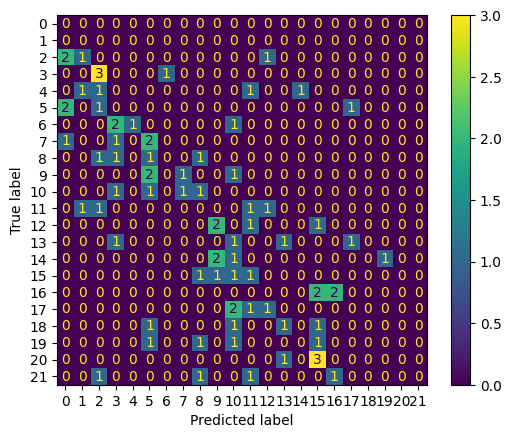

In [214]:


from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

accuracy = accuracy_score(test_targets, targets_predict)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(test_targets, targets_predict))

ConfusionMatrixDisplay.from_estimator(classifier, test_features, test_targets)

#### Results ####

#### Average distance from true result ####

In [215]:
import numpy as np
distances = np.abs(test_targets - targets_predict)
average_distance = np.mean(distances)
print(f"Average Distance from True Labels: {average_distance:.2f}")

Average Distance from True Labels: 3.70


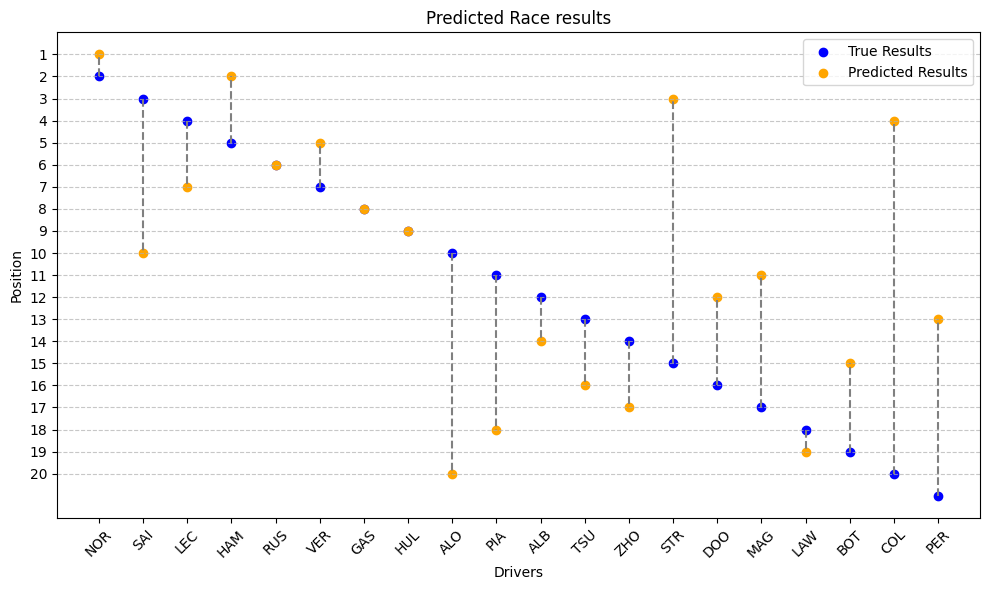

In [216]:
import matplotlib.pyplot as plt

driver_labels = test_le_driver.inverse_transform(test_features["DriverCode"])[-20:]
true_results = test_targets[-20:]
predicted_results = targets_predict[-20:]

plt.figure(figsize=(10, 6))

drivers = range(len(true_results))
plt.scatter(drivers, true_results, label='True Results', color='blue')
plt.scatter(drivers, predicted_results, label='Predicted Results', color='orange')

for j in drivers:
    plt.plot([j, j], [true_results.iloc[j], predicted_results[j]], color='gray', linestyle='--')

plt.xlabel('Drivers')
plt.ylabel('Position')
plt.title('Predicted Race results')
plt.xticks(drivers, driver_labels, rotation=45)
plt.yticks(np.arange(1, 21, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [217]:
labeled_results = test_le_driver.inverse_transform(test_features["DriverCode"])[-80:]
driver_dict = {}

for i in range(4):
    true_results = test_targets[i*20:(i+1)*20]
    driver_labels = labeled_results[i*20:(i+1)*20]
    predicted_results = targets_predict[i*20:(i+1)*20]
    
    for driver, true, predicted in zip(driver_labels, true_results, predicted_results):
        if driver not in driver_dict:
            driver_dict[driver] = []
        
        driver_dict[driver].append((true, predicted))

print(driver_dict)


{'VER': [(2, 4), (6, 5), (2, 1), (7, 5)], 'OCO': [(3, 6), (18, 17), (21, 20)], 'GAS': [(4, 2), (21, 15), (6, 10), (8, 8)], 'RUS': [(5, 5), (2, 1), (5, 3), (6, 6)], 'LEC': [(6, 7), (5, 20), (3, 4), (4, 7)], 'NOR': [(7, 9), (7, 7), (11, 7), (2, 1)], 'TSU': [(8, 18), (10, 9), (14, 8), (13, 16)], 'PIA': [(9, 8), (8, 8), (4, 2), (11, 18)], 'LAW': [(10, 14), (17, 10), (15, 5), (18, 19)], 'HAM': [(11, 11), (3, 3), (13, 11), (5, 2)], 'PER': [(12, 16), (11, 2), (18, 16), (21, 13)], 'BEA': [(13, 13)], 'BOT': [(14, 20), (19, 18), (12, 13), (19, 15)], 'ALO': [(15, 10), (12, 13), (8, 6), (10, 20)], 'ZHO': [(16, 1), (14, 12), (9, 17), (14, 17)], 'SAI': [(17, 19), (4, 4), (7, 12), (3, 10)], 'COL': [(18, 3), (15, 11), (20, 19), (20, 4)], 'ALB': [(19, 15), (20, 19), (16, 18), (12, 14)], 'STR': [(20, 17), (16, 16), (19, 15), (15, 3)], 'HUL': [(21, 12), (9, 6), (17, 14), (9, 9)], 'MAG': [(13, 14), (10, 9), (17, 11)], 'DOO': [(16, 12)]}


In [218]:
f1_points = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}

def calculate_f1_points(position):
    return f1_points.get(position, 0) # 0 Points for not top 10

driver_points = {}

for driver, results in driver_dict.items():
    real_points = sum(calculate_f1_points(true) for true, _ in results)
    predicted_points = sum(calculate_f1_points(predicted) for _, predicted in results)
    driver_points[driver] = {'real_points': real_points, 'predicted_points': predicted_points}

print(driver_points)

{'VER': {'real_points': 50, 'predicted_points': 57}, 'OCO': {'real_points': 15, 'predicted_points': 8}, 'GAS': {'real_points': 24, 'predicted_points': 23}, 'RUS': {'real_points': 46, 'predicted_points': 58}, 'LEC': {'real_points': 45, 'predicted_points': 24}, 'NOR': {'real_points': 30, 'predicted_points': 39}, 'TSU': {'real_points': 5, 'predicted_points': 6}, 'PIA': {'real_points': 18, 'predicted_points': 26}, 'LAW': {'real_points': 1, 'predicted_points': 11}, 'HAM': {'real_points': 25, 'predicted_points': 33}, 'PER': {'real_points': 0, 'predicted_points': 18}, 'BEA': {'real_points': 0, 'predicted_points': 0}, 'BOT': {'real_points': 0, 'predicted_points': 0}, 'ALO': {'real_points': 5, 'predicted_points': 9}, 'ZHO': {'real_points': 2, 'predicted_points': 25}, 'SAI': {'real_points': 33, 'predicted_points': 13}, 'COL': {'real_points': 0, 'predicted_points': 27}, 'ALB': {'real_points': 0, 'predicted_points': 0}, 'STR': {'real_points': 0, 'predicted_points': 15}, 'HUL': {'real_points': 4, '

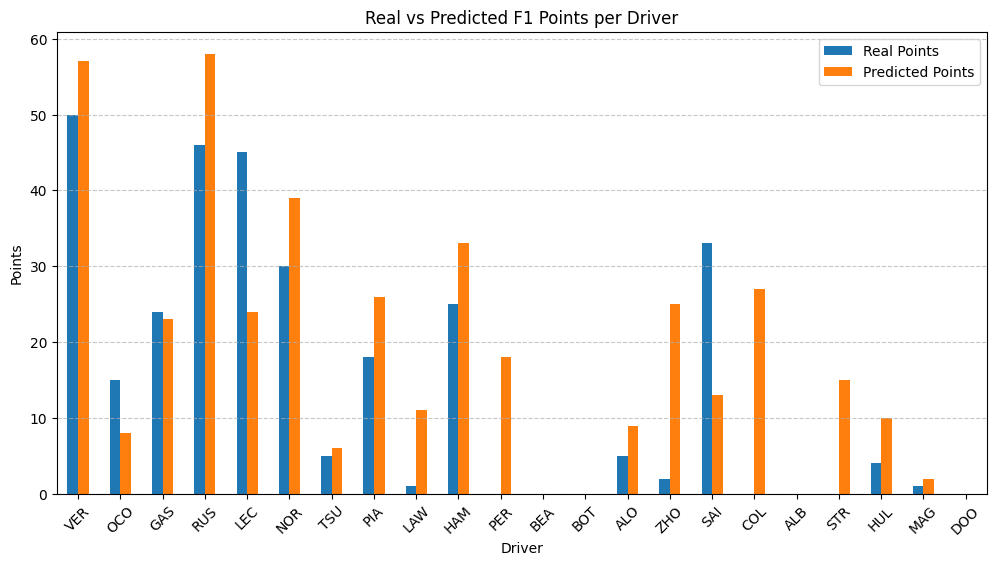

In [219]:
df = pd.DataFrame(driver_points).T

# Plot real vs predicted points
df.plot(kind='bar', figsize=(12, 6))
plt.title("Real vs Predicted F1 Points per Driver")
plt.xlabel("Driver")
plt.ylabel("Points")
plt.xticks(rotation=45)
plt.legend(["Real Points", "Predicted Points"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()